In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [10]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [11]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [12]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [13]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

In [14]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('dados_imobilidarios_bcb.csv')
df.head(len(df))

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-01-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-02-28,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-04-30,2.562713e+07,2.727207e+08,2.022522e+09,2.270508e+09,5.414101e+09,3.389500e+08,3.905183e+07,5.447550e+08,6.388303e+08,2.707574e+11,1.925519e+10,NaN,3.255851e+11,9861376.64,6.191287e+08,1.146923e+09,9.280301e+09,8.901810e+09,2.325760e+07,2.889585e+08,5.862522e+07,1.598816e+08,5.617836e+08,1.032005e+10,5.727688e+10,1.221111e+11,1.802609e+11,1.890793e+09,1.461609e+09,2.166387e+10,2.672295e+10,1.49,2.39,1.29,1.22,4.11,0.28,0.12,0.57,0.01,480464916610,1.304882e+09,NaN,4.109793e+10,1.141025e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-05-31,4.824127e+07,2.739426e+08,2.397400e+09,2.675238e+09,6.697185e+09,4.018676e+08,2

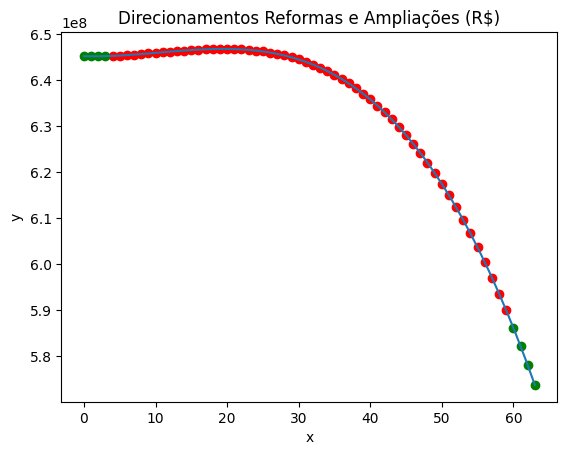

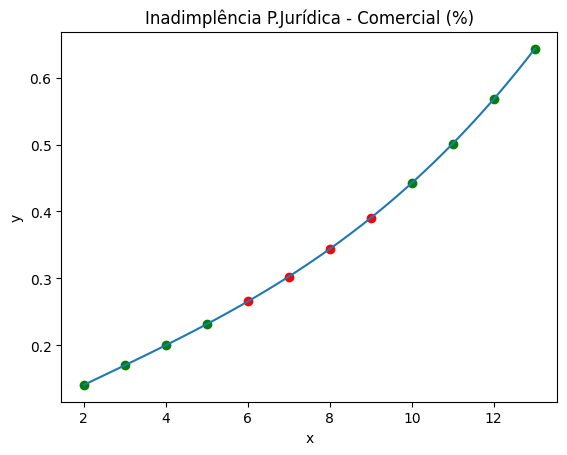

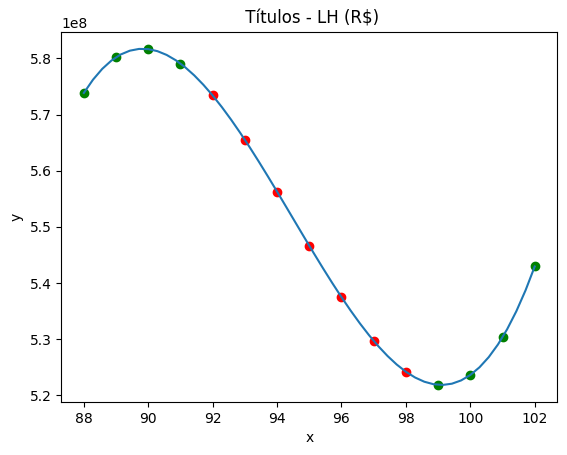

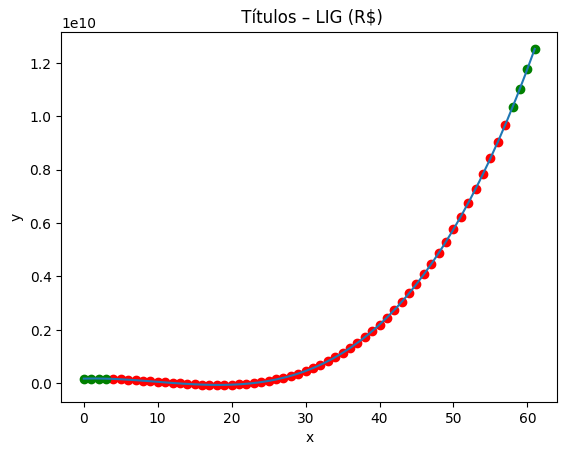

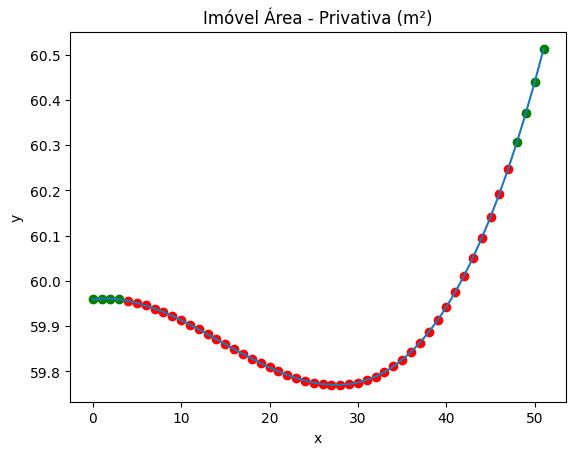

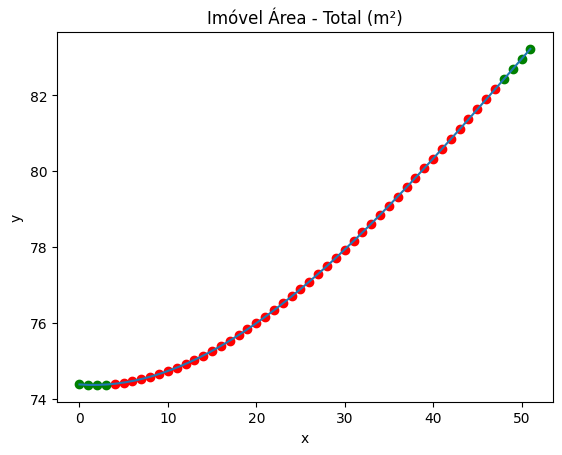

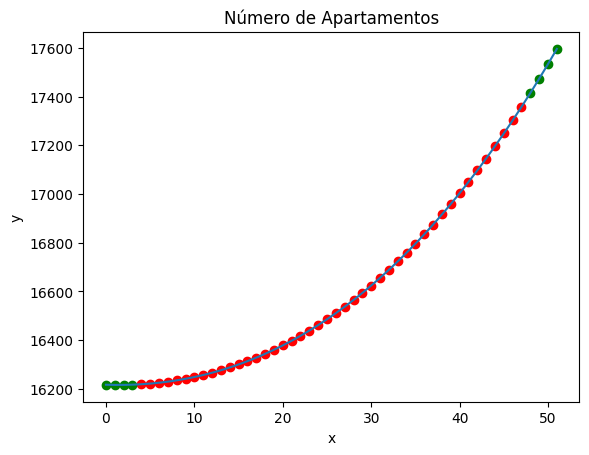

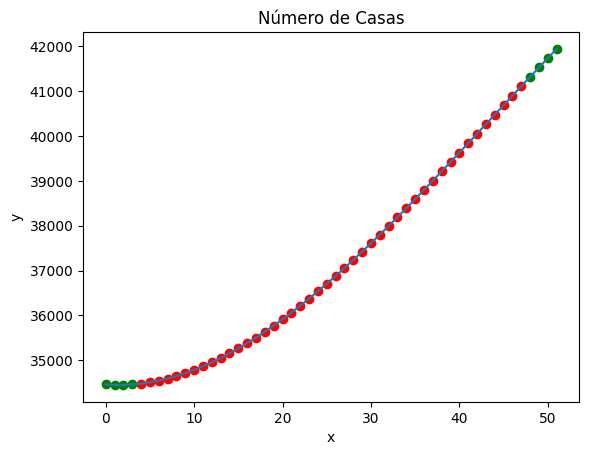

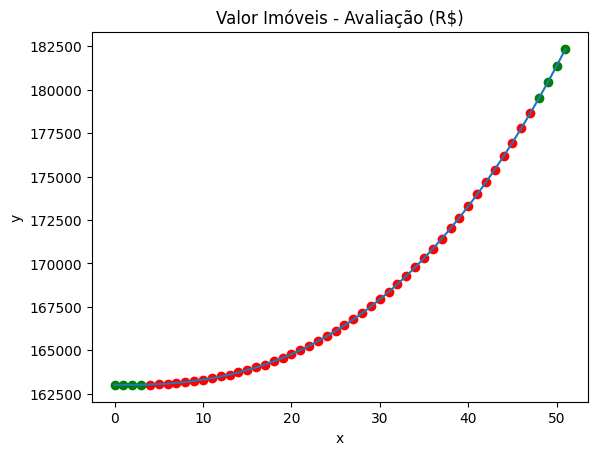

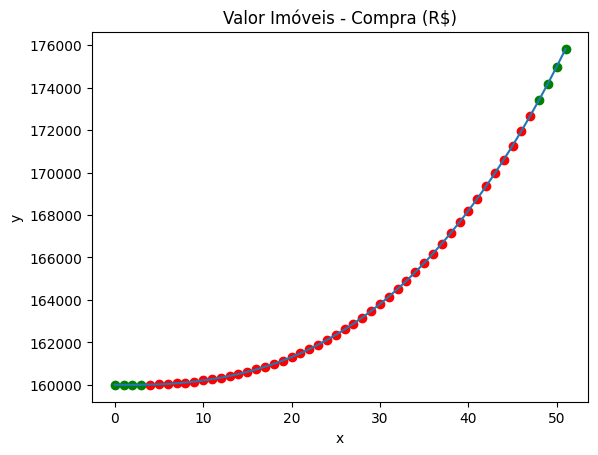

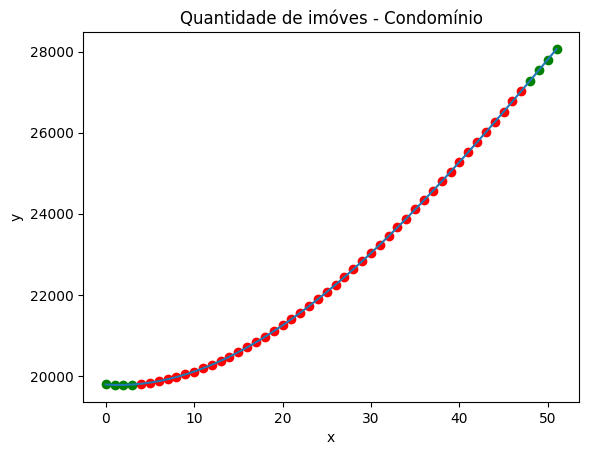

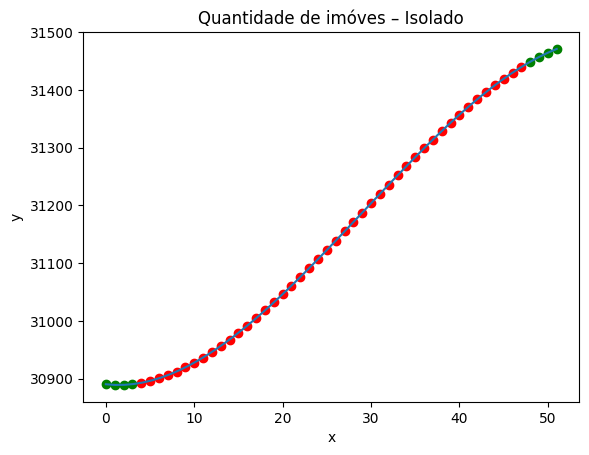

,DateTime,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
0,2014-01-30,4.662068e+07,2.460053e+08,1.898133e+09,3.272294e+09,4.400998e+09,1.316370e+08,7.238672e+07,4.184620e+08,5.181179e+08,3.244417e+11,2.289097e+10,6.452397e+08,3.542036e+11,1.514587e+07,9.680057e+08,1.767638e+09,8.931303e+09,9.661752e+09,1.715931e+07,3.651412e+08,4.216442e+07,4.049929e+08,9.775880e+08,1.155475e+10,6.845529e+10,1.518386e+11,2.057276e+11,1.303650e+09,3.427114e+09,2.663783e+10,2.698349e+10,1.450000,2.192000,1.437200,1.033200,4.644000,0.406400,0.701200,0.696800,0.111905,5.012533e+11,1.268306e+09,1.772018e+08,5.081997e+10,1.537490e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
1,2014-02-28,4.709125e+07,2.416478e+08,1.849558e+09,3.301831e+09,4.259555e+09,1.192469e+08,7.712894e+07,3.982665e+08,4.995552e+08,3.286953e+11,2.321679e+10,6.452397e+08,3.563160e+11,1.600579e+07,9.975955e+08,1.824461e+09,8.958574e+09,9.740327e+09,1.711733e+07,3.874777e+08,4.394367e+07,4.243992e+08,1.028190e+09,1.160723e+10,6.894835e+10,1.544679e+11,2.078501e+11,1.270503e+09,3.833028e+09,2.671452e+10,2.699683e+10,1.460000,2.181615,1.468354,1.038969,4.728615,0.451400,0.768123,0.721031,0.128723,5.019774e+11,1.262515e+09,1.772018e+08,5.158643e+10,1.567650e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
2,2014-03-30,4.794768e+07,2.390401e+08,1.804611e+09,3.335643e+09,4.195400e+09,1.078194e+08,8.304593e+07,3.804889e+08,4.800990e+08,3.328937e+11,2.354158e+10,6.452397e+08,3.584188e+11,1.699932e+07,1.027706e+09,1.874379e+09,9.032121e+09,9.784339e+09,1.705364e+07,4.092930e+08,4.562957e+07,4.471340e+08,1.077640e+09,1.165698e+10,6.921027e+10,1.564085e+11,2.108407e+11,1.240668e+09,4.227335e+09,2.679211e+10,2.700351e+10,1.467407,2.166060,1.502058,1.050080,4.814912,0.486585,0.829234,0.748809,0.145245,5.025943e+11,1.257734e+09,1.772018e+08,5.233392e+10,1.597056e+11,59.960000,74.370000,16216.000000,34458.000000,163009.550000,160000.000000,19784.000000,30890.000000
3,2014-04-30,4.848135e+07,2.369114e+08,1.755560e+09,3.398570e+09,4.075622e+09,9.608264e+07,8.617773e+07,3.636921e+08,4.633681e+08,3.369619e+11,2.386586e+10,6.452397e+08,3.603753e+11,1.819247e+07,1.058005e+09,1.917523e+09,9.082856e+09,9.882895e+09,1.719268e+0

In [15]:
df_interpolated = read_csv_replace_missing_by_polynomial('dados_imobilidarios_bcb.csv', 0, 0)
df_interpolated

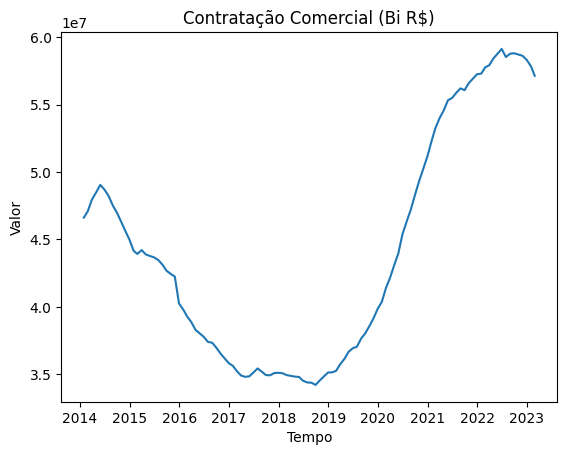

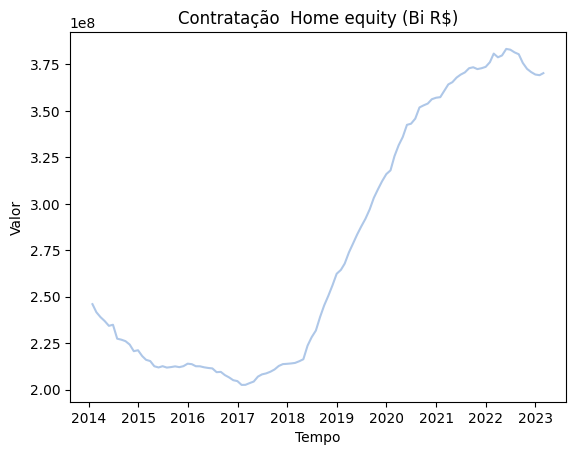

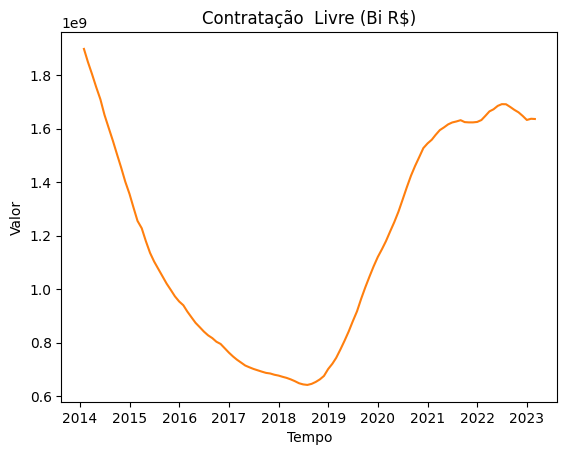

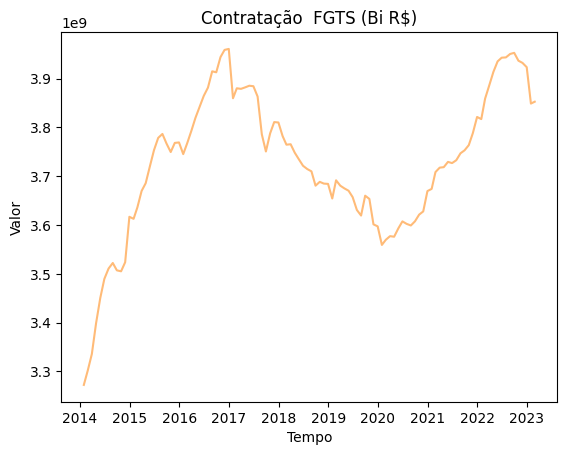

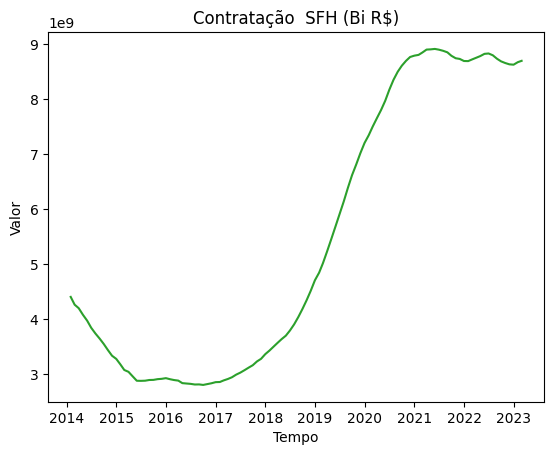

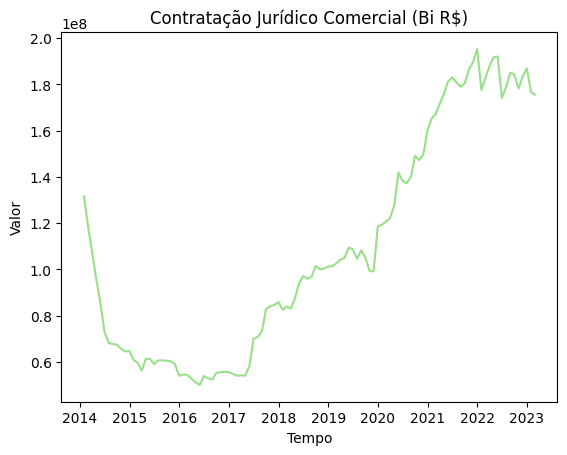

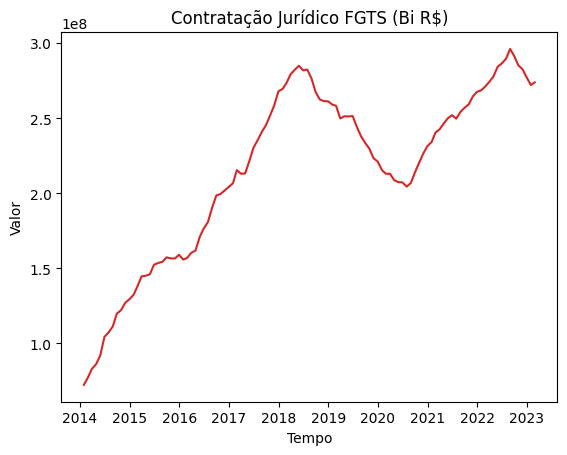

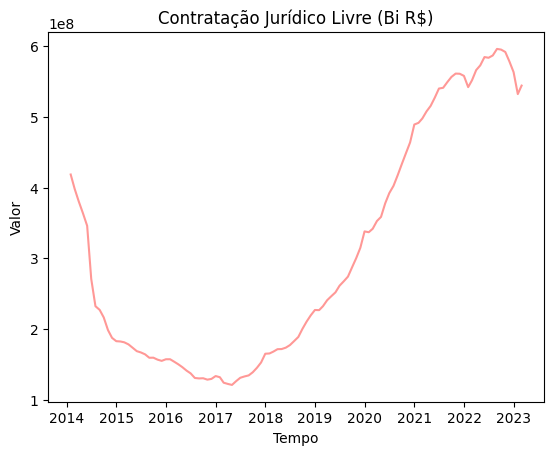

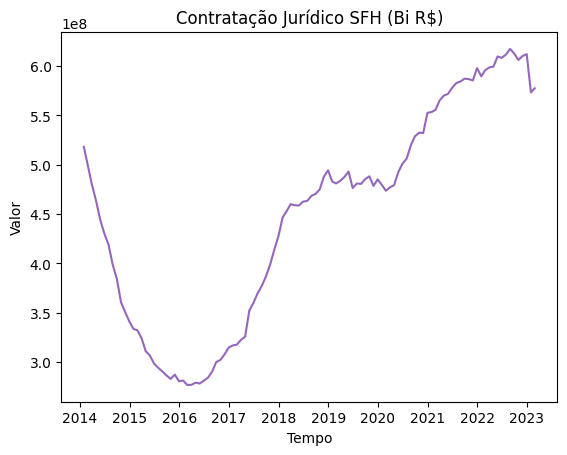

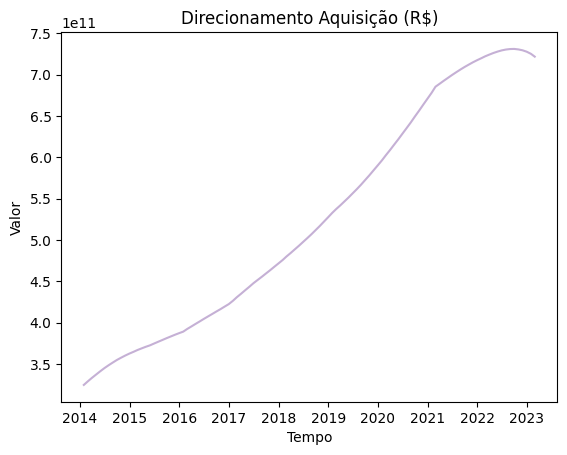

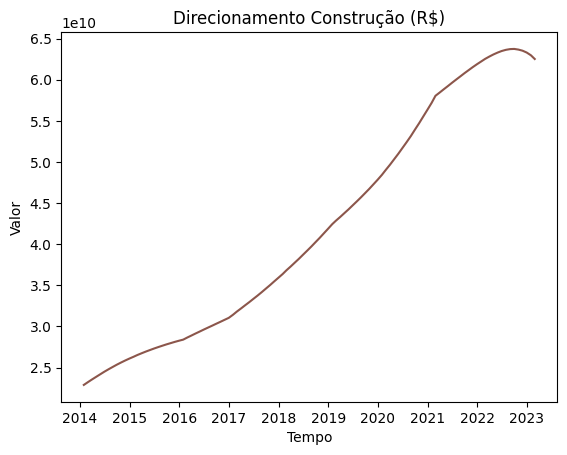

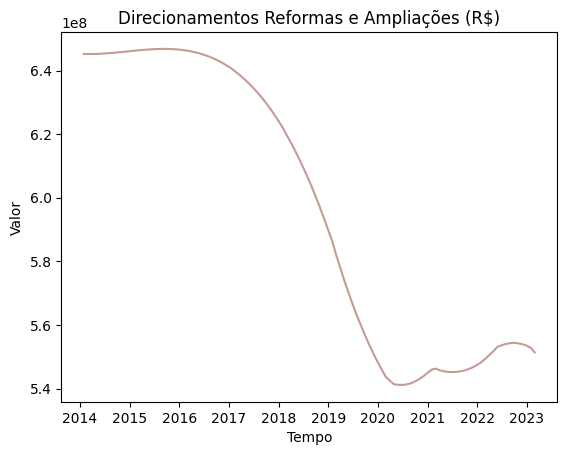

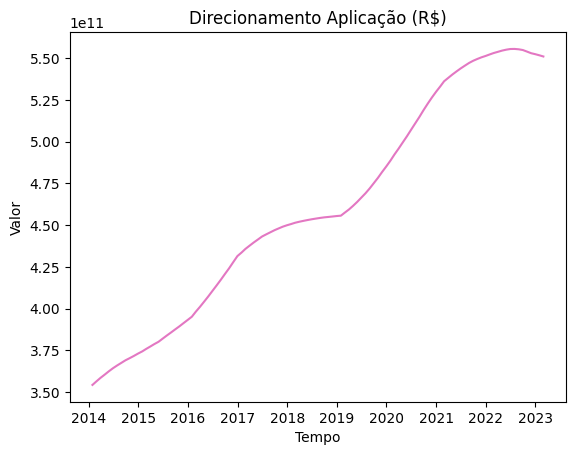

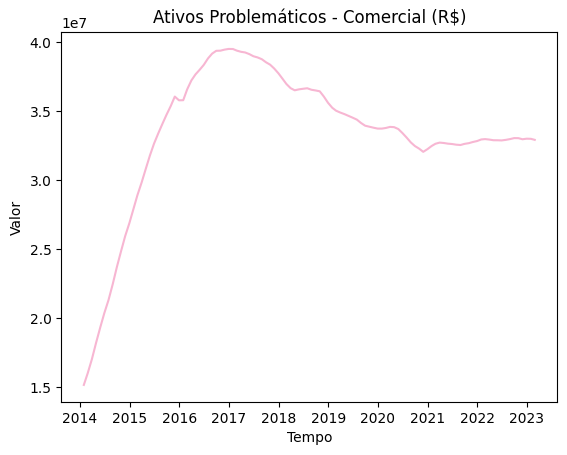

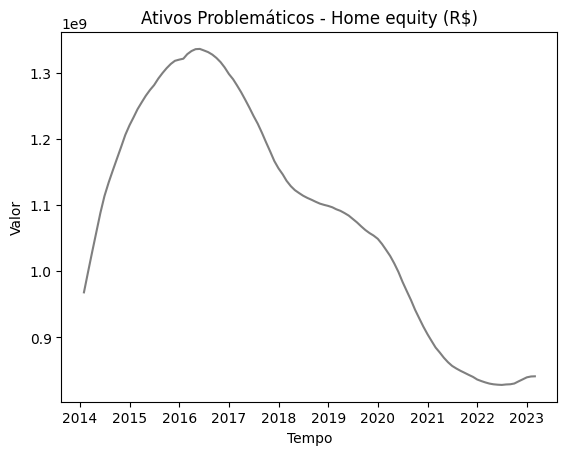

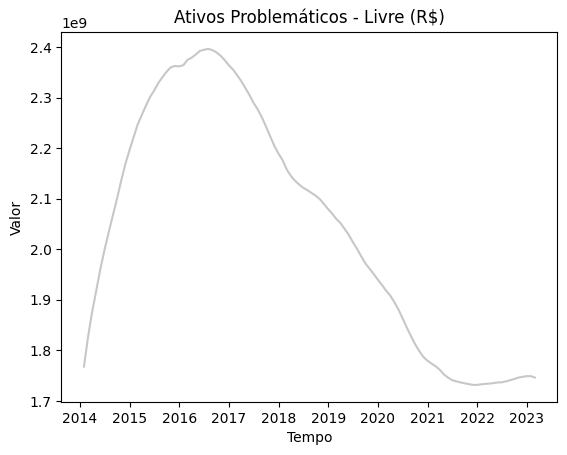

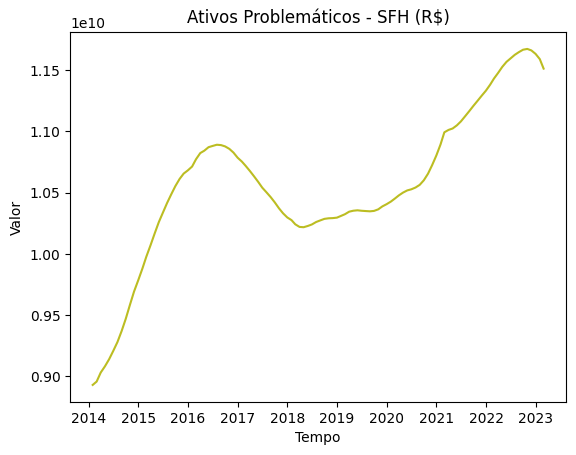

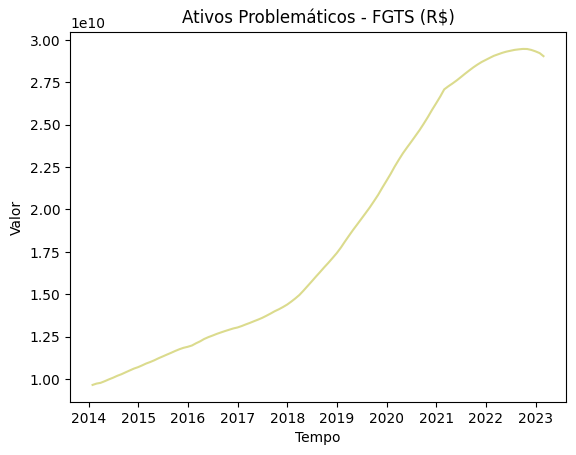

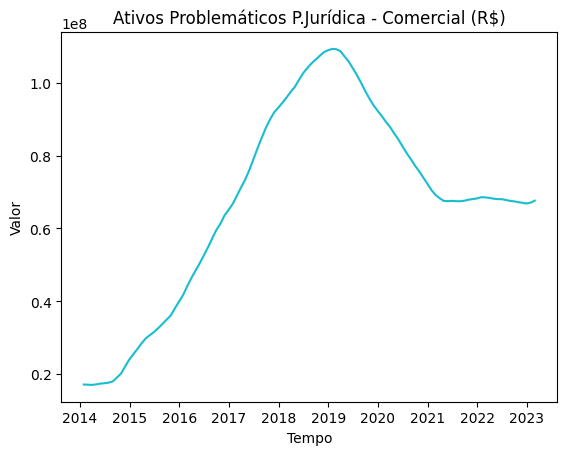

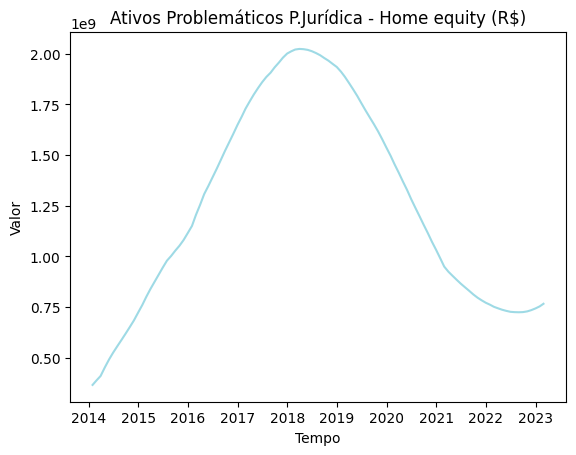

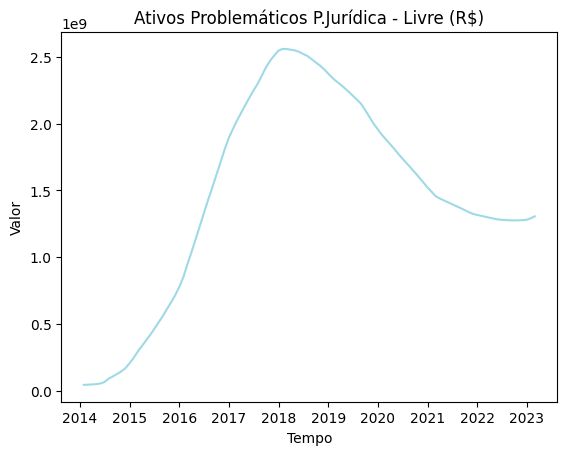

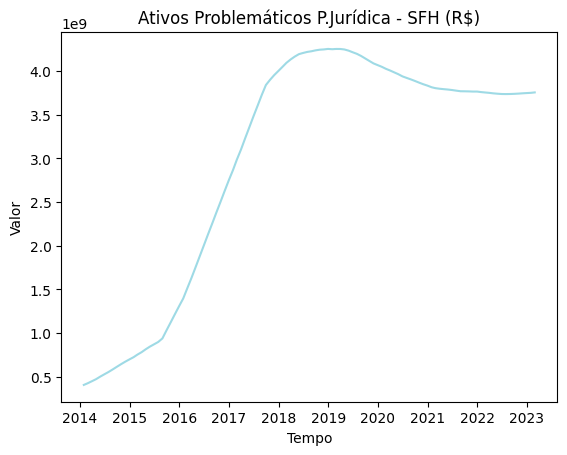

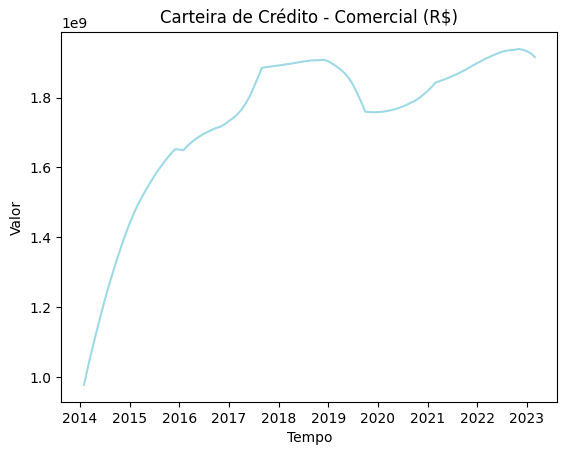

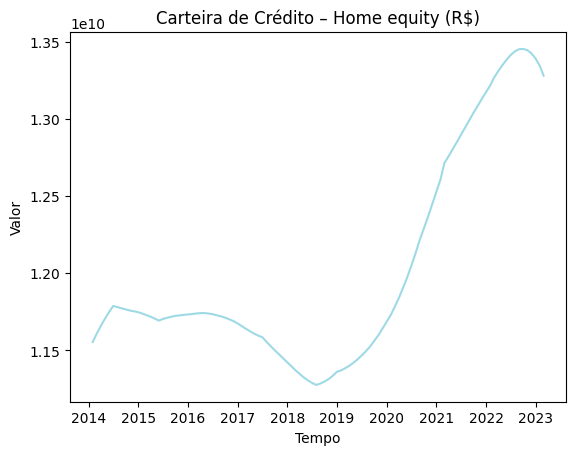

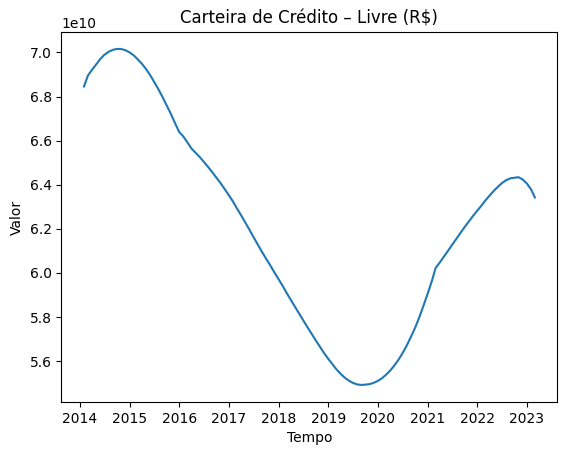

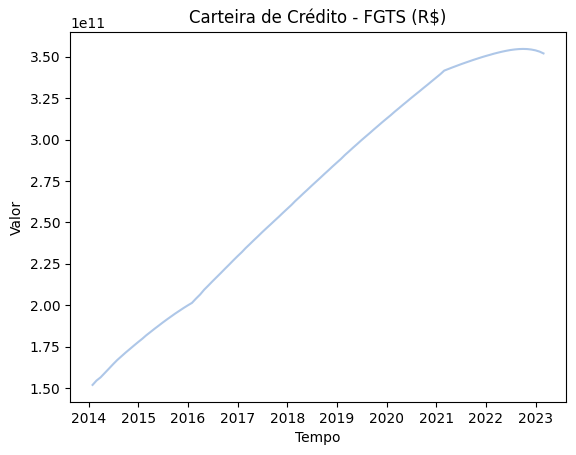

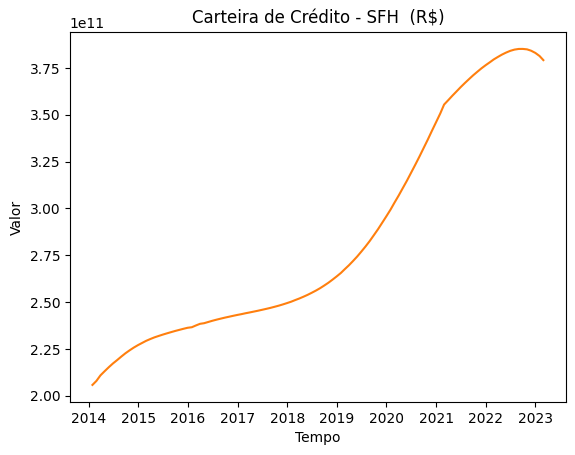

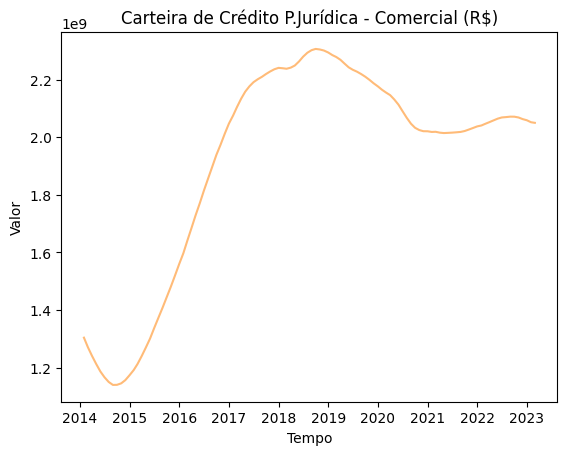

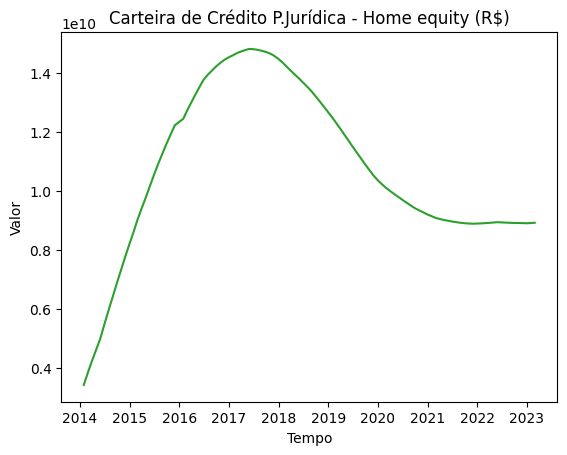

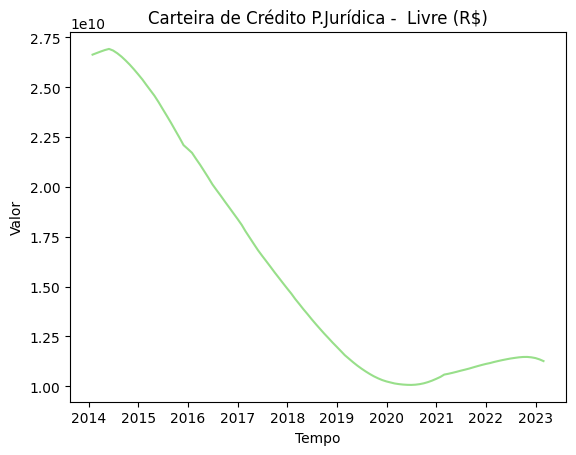

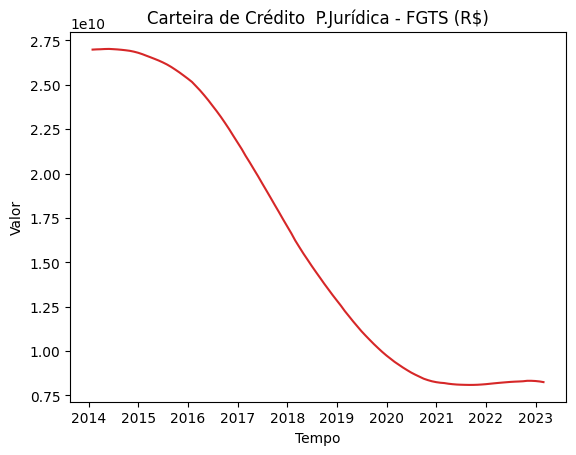

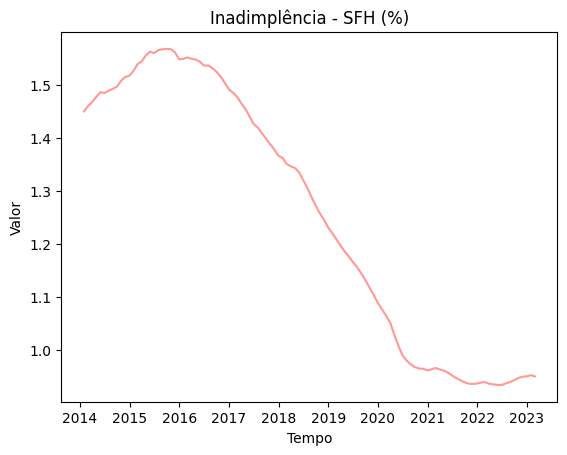

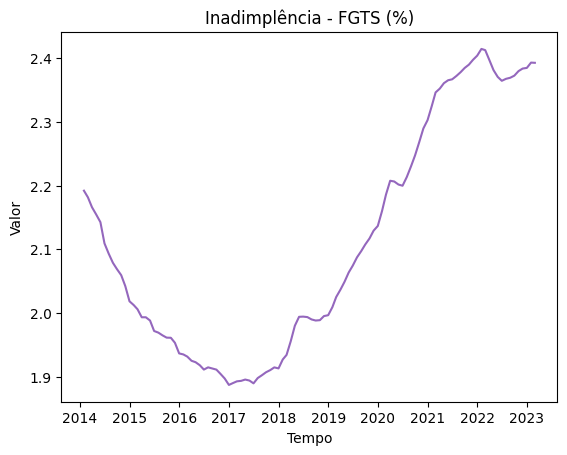

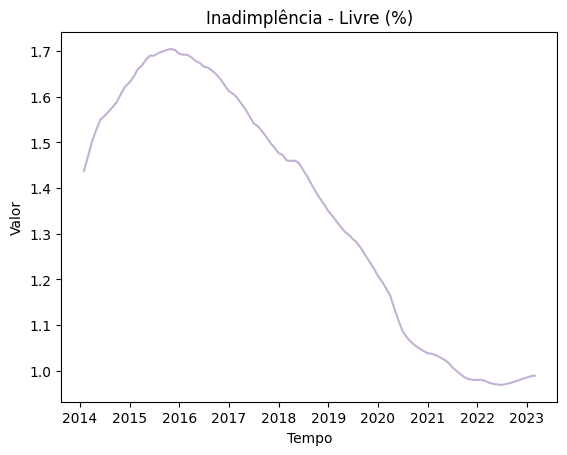

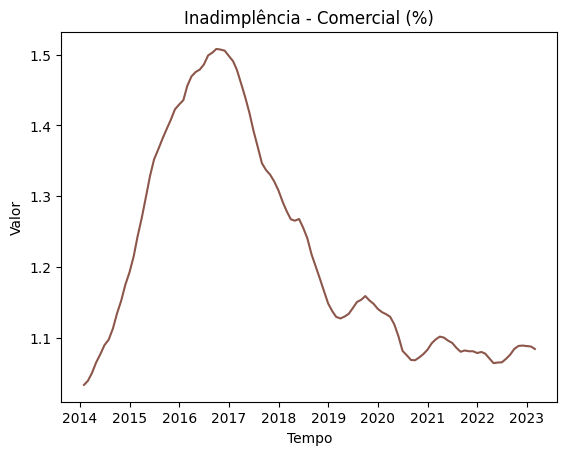

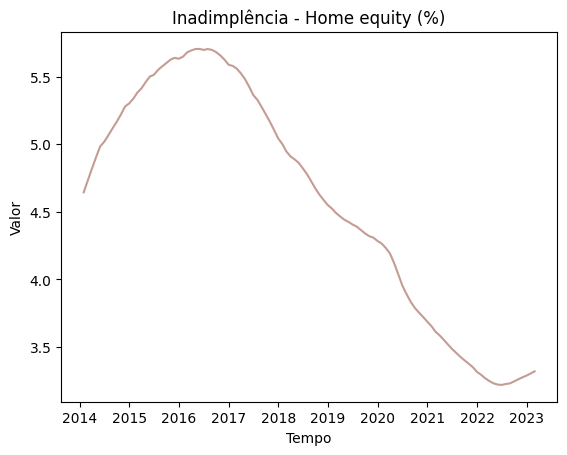

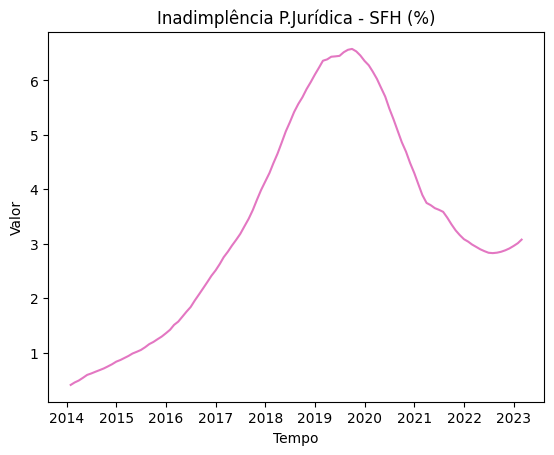

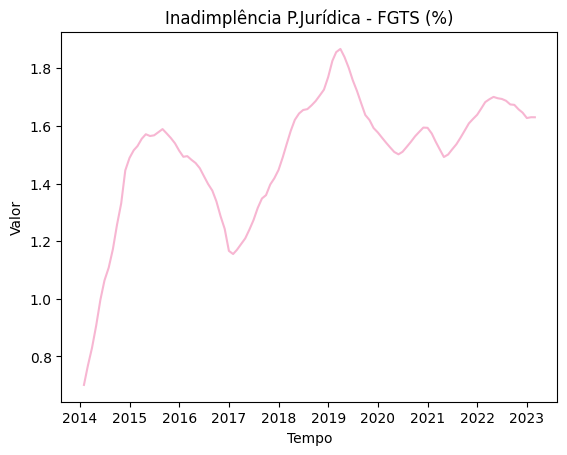

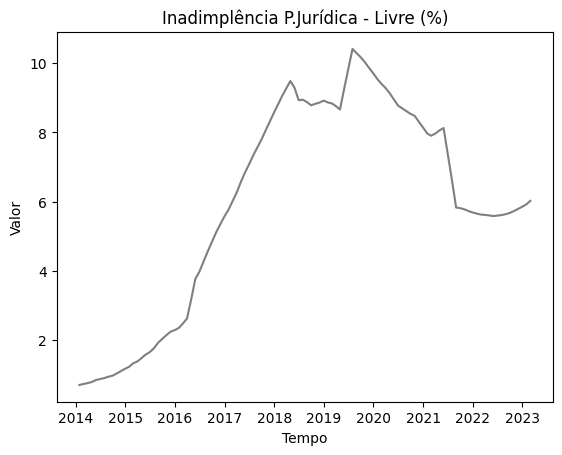

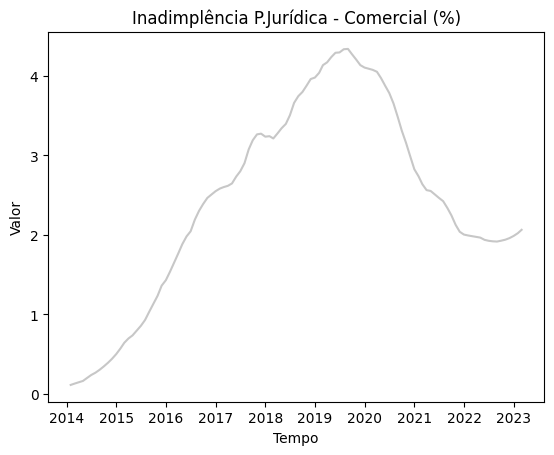

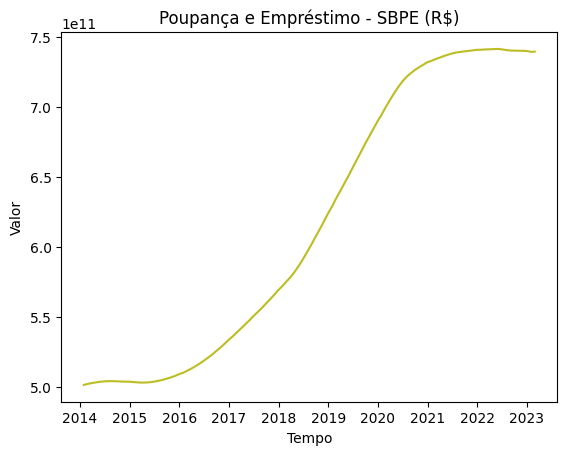

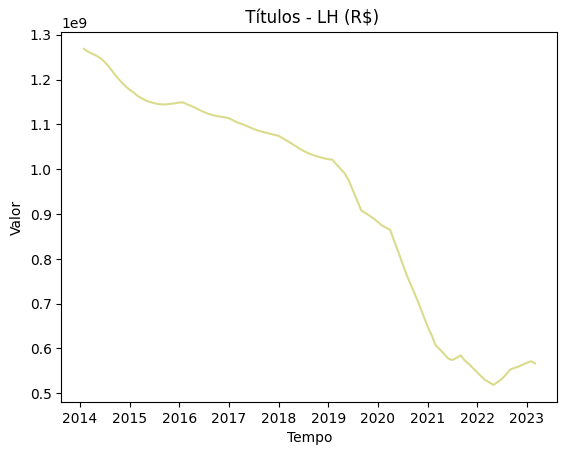

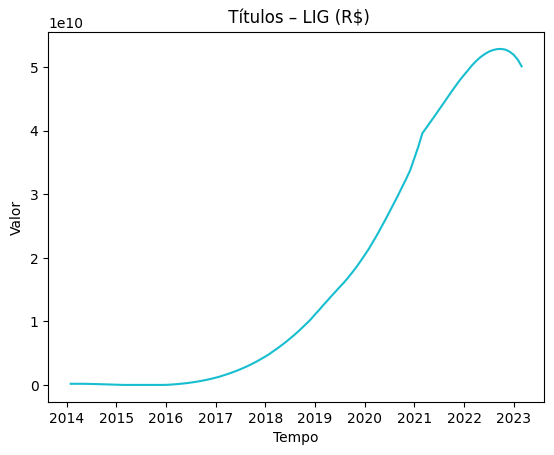

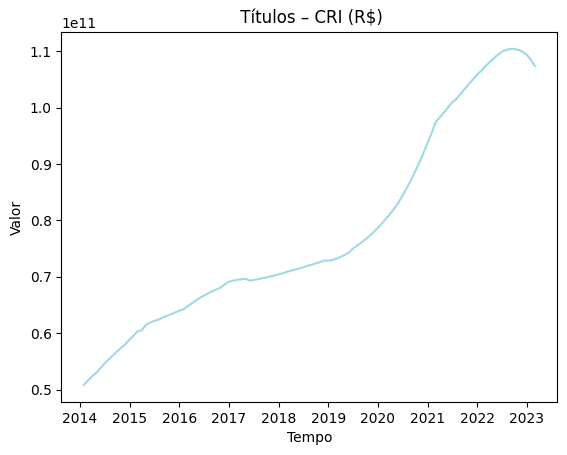

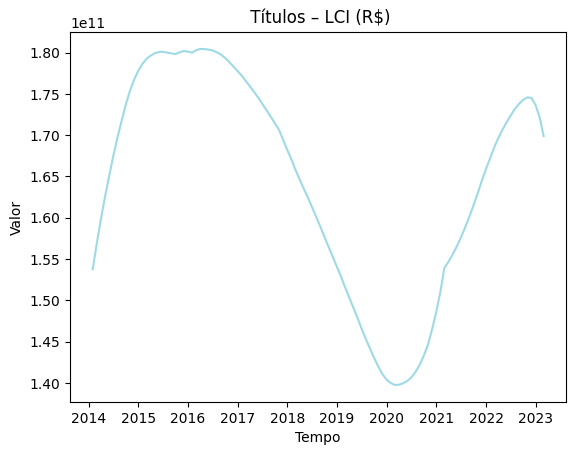

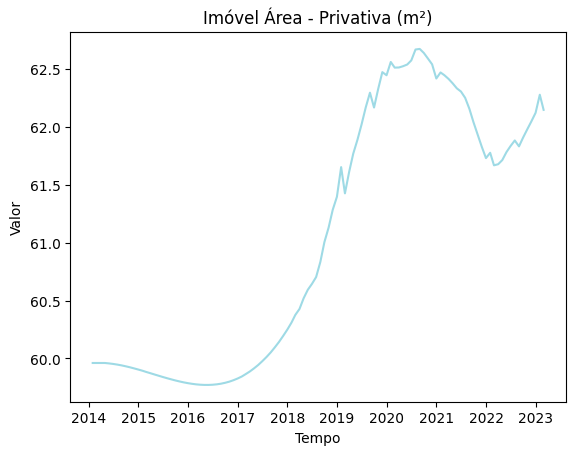

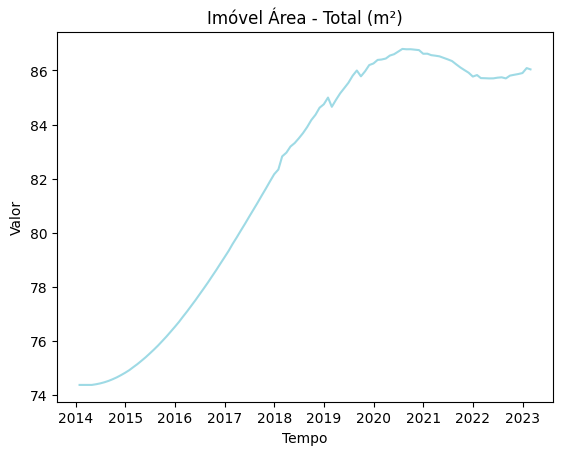

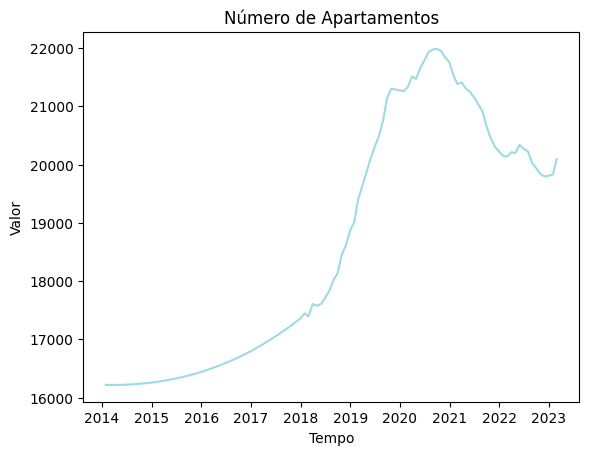

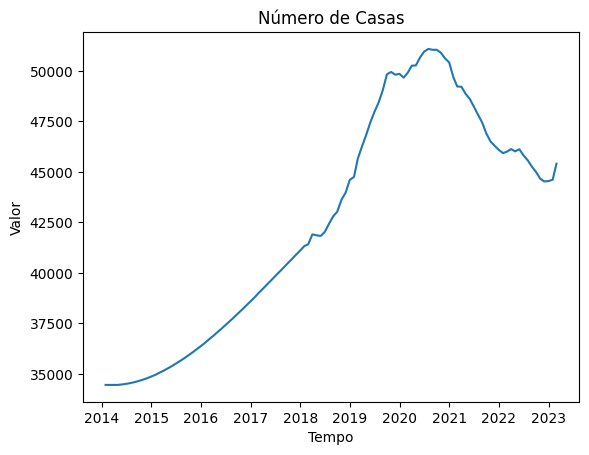

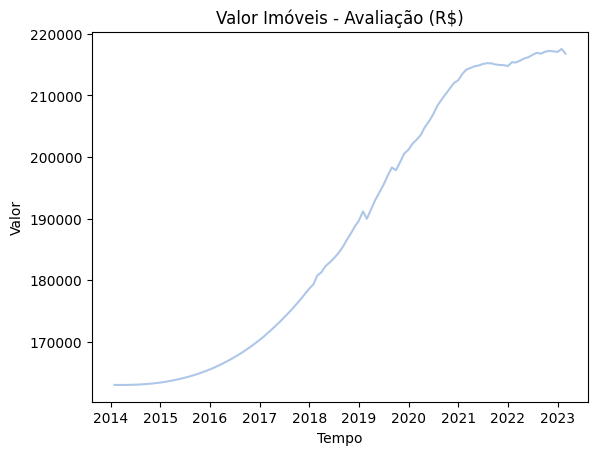

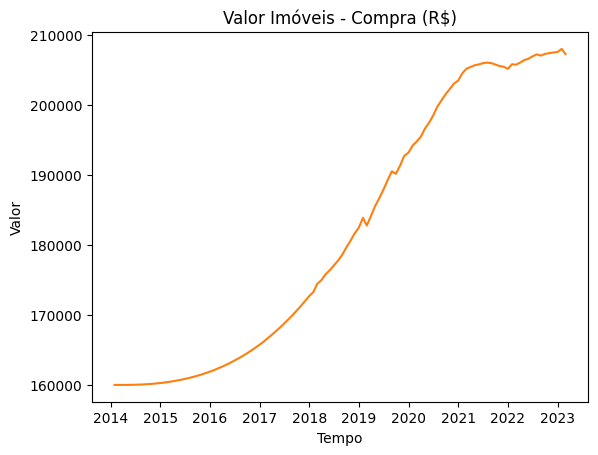

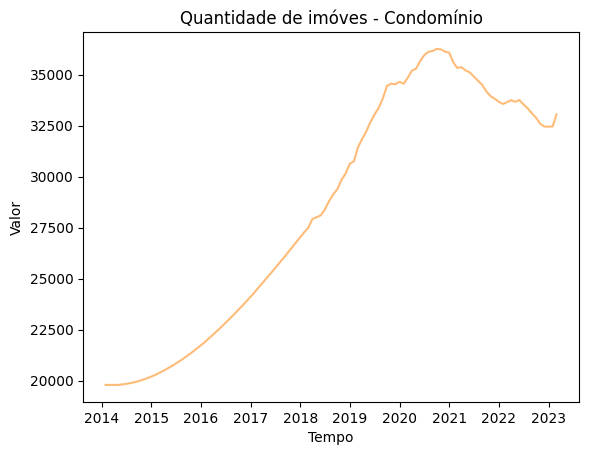

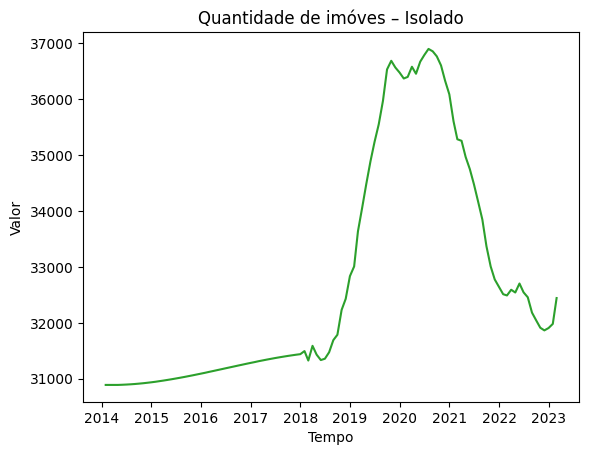

In [16]:
df_interpolated['DateTime'] = pd.to_datetime(df_interpolated['DateTime'])
df_interpolated.set_index('DateTime', inplace=True)
plot_columns(df_interpolated)

In [17]:
colunas_porcentagem = ['Inadimplência - SFH (%)',
                       'Inadimplência - FGTS (%)',
                       'Inadimplência - Livre (%)',
                       'Inadimplência - Comercial (%)',
                       'Inadimplência - Home equity (%)',
                       'Inadimplência P.Jurídica - SFH (%)',
                       'Inadimplência P.Jurídica - FGTS (%)',
                       'Inadimplência P.Jurídica - Livre (%)',
                       'Inadimplência P.Jurídica - Comercial (%)']

df_by_year = df_interpolated.copy()
df_by_year = df_by_year.resample('Y').sum()
df_by_year[colunas_porcentagem] = df_by_year[colunas_porcentagem] /12
df_by_year

,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31,5.676413e+08,2.779340e+09,1.954361e+10,4.143397e+10,4.570163e+10,1.011496e+09,1.232343e+09,3.420812e+09,5.088494e+09,4.142818e+12,2.950026e+11,7.746345e+09,4.373070e+12,2.510976e+08,1.332574e+10,2.404456e+10,1.115407e+11,1.218988e+11,2.245660e+08,6.448063e+09,1.124945e+09,6.534598e+09,1.471761e+10,1.406399e+11,8.362613e+11,1.982139e+12,2.609380e+12,1.428270e+10,6.909529e+10,3.180520e+11,3.235339e+11,1.487081,2.108868,1.553176,1.101409,5.020584,0.624259,1.089060,0.893641,0.269034,6.038778e+12,1.473856e+10,1.540390e+09,6.585922e+11,2.010185e+12,719.303556,894.066851,194735.915934,414993.006897,1.957410e+06,1.920887e+06,238875.435475,370853.487356
2015-12-31,5.179392e+08,2.561731e+09,1.327596e+10,4.469706e+10,3.539769e+10,7.138599e+08,1.796510e+09,2.000000e+09,3.627202e+09,4.509034e+12,3.283036e+11,7.759626e+09,4.598532e+12,3.910324e+08,1.540397e+10,2.773885e+10,1.240890e+11,1.366454e+11,3.884182e+08,1.138136e+10,5.913002e+09,1.128846e+10,1.890840e+10,1.406336e+11,8.202959e+11,2.282392e+12,2.791847e+12,1.633077e+10,1.277445e+11,2.842002e+11,3.136081e+11,1.555684,1.975818,1.685830,1.342337,5.519741,1.091256,1.554716,1.744583,0.951298,6.056762e+12,1.381905e+10,2.283372e+07,7.450342e+11,2.157580e+12,718.029315,907.772025,196102.393453,427315.523847,1.972339e+06,1.931955e+06,251243.939372,372173.977928
2016-12-31,4.524144e+08,2.516859e+09,1.011370e+10,4.640544e+10,3.407411e+10,6.445345e+08,2.158540e+09,1.665337e+09,3.472210e+09,4.868614e+12,3.567817e+11,7.732887e+09,4.951267e+12,4.590215e+08,1.589192e+10,2.859176e+10,1.300214e+11,1.509605e+11,6.452471e+08,1.690491e+10,1.647912e+10,2.479509e+10,2.034595e+10,1.406577e+11,7.785462e+11,2.587089e+12,2.881541e+12,2.196026e+10,1.642835e+11,2.403107e+11,2.830484e+11,1.531973,1.914080,1.661032,1.485109,5.674187,1.931095,1.385614,3.998560,2.105125,6.245406e+12,1.353999e+10,5.785002e+09,8.010136e+11,2.155760e+12,717.421129,934.230405,199395.687564,450427.186233,2.014251e+06,1.965039e+06,275475.913918,374346.959879
2017-12-31,4.213689e+08,2.497710e+09,8.456309e+09,4.607888e+10,3.680756e+10,8.272860e+08,2.800465e+09,1.622534e+09,4.367617e+09,5.389552e+12,4.032688e+11,7.598330e+09,5.315585e+12,4.656517e+08,1.4713

In [18]:
df_csv = df_by_year.copy()
df_csv['Ano'] = df_csv.index.year
df_csv.set_index('Ano', inplace=True)
df_csv

,Contratação Comercial (Bi R$),Contratação Home equity (Bi R$),Contratação Livre (Bi R$),Contratação FGTS (Bi R$),Contratação SFH (Bi R$),Contratação Jurídico Comercial (Bi R$),Contratação Jurídico FGTS (Bi R$),Contratação Jurídico Livre (Bi R$),Contratação Jurídico SFH (Bi R$),Direcionamento Aquisição (R$),Direcionamento Construção (R$),Direcionamentos Reformas e Ampliações (R$),Direcionamento Aplicação (R$),Ativos Problemáticos - Comercial (R$),Ativos Problemáticos - Home equity (R$),Ativos Problemáticos - Livre (R$),Ativos Problemáticos - SFH (R$),Ativos Problemáticos - FGTS (R$),Ativos Problemáticos P.Jurídica - Comercial (R$),Ativos Problemáticos P.Jurídica - Home equity (R$),Ativos Problemáticos P.Jurídica - Livre (R$),Ativos Problemáticos P.Jurídica - SFH (R$),Carteira de Crédito - Comercial (R$),Carteira de Crédito – Home equity (R$),Carteira de Crédito – Livre (R$),Carteira de Crédito - FGTS (R$),Carteira de Crédito - SFH (R$),Carteira de Crédito P.Jurídica - Comercial (R$),Carteira de Crédito P.Jurídica - Home equity (R$),Carteira de Crédito P.Jurídica - Livre (R$),Carteira de Crédito P.Jurídica - FGTS (R$),Inadimplência - SFH (%),Inadimplência - FGTS (%),Inadimplência - Livre (%),Inadimplência - Comercial (%),Inadimplência - Home equity (%),Inadimplência P.Jurídica - SFH (%),Inadimplência P.Jurídica - FGTS (%),Inadimplência P.Jurídica - Livre (%),Inadimplência P.Jurídica - Comercial (%),Poupança e Empréstimo - SBPE (R$),Títulos - LH (R$),Títulos – LIG (R$),Títulos – CRI (R$),Títulos – LCI (R$),Imóvel Área - Privativa (m²),Imóvel Área - Total (m²),Número de Apartamentos,Número de Casas,Valor Imóveis - Avaliação (R$),Valor Imóveis - Compra (R$),Quantidade de imóves - Condomínio,Quantidade de imóves – Isolado
Ano,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014,5.676413e+08,2.779340e+09,1.954361e+10,4.143397e+10,4.570163e+10,1.011496e+09,1.232343e+09,3.420812e+09,5.088494e+09,4.142818e+12,2.950026e+11,7.746345e+09,4.373070e+12,2.510976e+08,1.332574e+10,2.404456e+10,1.115407e+11,1.218988e+11,2.245660e+08,6.448063e+09,1.124945e+09,6.534598e+09,1.471761e+10,1.406399e+11,8.362613e+11,1.982139e+12,2.609380e+12,1.428270e+10,6.909529e+10,3.180520e+11,3.235339e+11,1.487081,2.108868,1.553176,1.101409,5.020584,0.624259,1.089060,0.893641,0.269034,6.038778e+12,1.473856e+10,1.540390e+09,6.585922e+11,2.010185e+12,719.303556,894.066851,194735.915934,414993.006897,1.957410e+06,1.920887e+06,238875.435475,370853.487356
2015,5.179392e+08,2.561731e+09,1.327596e+10,4.469706e+10,3.539769e+10,7.138599e+08,1.796510e+09,2.000000e+09,3.627202e+09,4.509034e+12,3.283036e+11,7.759626e+09,4.598532e+12,3.910324e+08,1.540397e+10,2.773885e+10,1.240890e+11,1.366454e+11,3.884182e+08,1.138136e+10,5.913002e+09,1.128846e+10,1.890840e+10,1.406336e+11,8.202959e+11,2.282392e+12,2.791847e+12,1.633077e+10,1.277445e+11,2.842002e+11,3.136081e+11,1.555684,1.975818,1.685830,1.342337,5.519741,1.091256,1.554716,1.744583,0.951298,6.056762e+12,1.381905e+10,2.283372e+07,7.450342e+11,2.157580e+12,718.029315,907.772025,196102.393453,427315.523847,1.972339e+06,1.931955e+06,251243.939372,372173.977928
2016,4.524144e+08,2.516859e+09,1.011370e+10,4.640544e+10,3.407411e+10,6.445345e+08,2.158540e+09,1.665337e+09,3.472210e+09,4.868614e+12,3.567817e+11,7.732887e+09,4.951267e+12,4.590215e+08,1.589192e+10,2.859176e+10,1.300214e+11,1.509605e+11,6.452471e+08,1.690491e+10,1.647912e+10,2.479509e+10,2.034595e+10,1.406577e+11,7.785462e+11,2.587089e+12,2.881541e+12,2.196026e+10,1.642835e+11,2.403107e+11,2.830484e+11,1.531973,1.914080,1.661032,1.485109,5.674187,1.931095,1.385614,3.998560,2.105125,6.245406e+12,1.353999e+10,5.785002e+09,8.010136e+11,2.155760e+12,717.421129,934.230405,199395.687564,450427.186233,2.014251e+06,1.965039e+06,275475.913918,374346.959879
2017,4.213689e+08,2.497710e+09,8.456309e+09,4.607888e+10,3.680756e+10,8.272860e+08,2.800465e+09,1.622534e+09,4.367617e+09,5.389552e+12,4.032688e+11,7.598330e+09,5.315585e+12,4.656517e+08,1.471364e+10,2.734583e+10,1.262927e

In [20]:
df_csv.to_csv('2014_01_imob.csv', index=True)